# Plot Renewable Suitability Maps

This notebook provides the code to plot the renewable suitability maps for solar and wind.

In [15]:
import os
import glob

import yaml
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec

from matplotlib.colors import ListedColormap
import matplotlib as mpl
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings("ignore")

In [5]:
# set year of analysis
year = 2050

# data dir
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data', 'input_data')

# output data dir
output_dir = os.path.join(os.path.dirname(os.getcwd()), 'data', 'output_data')

# figure dir
figure_dir = os.path.join(os.path.dirname(os.getcwd()), 'figures')

# state raster path
state_raster_path = os.path.join(data_dir, 'state_raster', 'state_raster_land.tif')

# processed raster dir
processed_raster_dir = os.path.join(data_dir, 'input_data', 'compiled_raster_data')

# west raster data dir
west_raster_dir = os.path.join(data_dir, 'west_raster_data')

# rasters with land area extent
land_area_raster_dir = os.path.join(west_raster_dir, 'land_area')

base_wind_exc_path = os.path.join(land_area_raster_dir, 'gridcerf_wind_suitability_120m_hubheight.tif')

base_solar_exc_path = os.path.join(land_area_raster_dir, 'gridcerf_solar_pv_suitability.tif')

# dac exclusion raster path
dac_raster_path = os.path.join(land_area_raster_dir, 'gridcerf_usceq_cejst_exclude_all_dacs.tif')

# farmland exclusion raster path
farm_raster_path = os.path.join(land_area_raster_dir, 'gridcerf_usda_combined_important_farmland.tif')

env_1_path = os.path.join(land_area_raster_dir, 'gridcerf_combined_environment_level_1.tif')
env_1_1km_path = os.path.join(land_area_raster_dir, 'gridcerf_combined_environment_level_1_1buff.tif')
env_1_5km_path = os.path.join(land_area_raster_dir, 'gridcerf_combined_environment_level_1_5buff.tif')
env_1_10km_path = os.path.join(land_area_raster_dir, 'gridcerf_combined_environment_level_1_10buff.tif')

env_2_path = os.path.join(land_area_raster_dir, 'gridcerf_combined_environment_level_2.tif')
env_2_1km_path = os.path.join(land_area_raster_dir, 'gridcerf_combined_environment_level_2_1buff.tif')
env_2_5km_path = os.path.join(land_area_raster_dir, 'gridcerf_combined_environment_level_2_5buff.tif')
env_2_10km_path = os.path.join(land_area_raster_dir, 'gridcerf_combined_environment_level_2_10buff.tif')
                          
env_3_path = os.path.join(land_area_raster_dir, 'gridcerf_combined_environment_level_3.tif')
env_3_1km_path = os.path.join(land_area_raster_dir, 'gridcerf_combined_environment_level_3_1buff.tif')
env_3_5km_path = os.path.join(land_area_raster_dir, 'gridcerf_combined_environment_level_3_5buff.tif')
env_3_10km_path = os.path.join(land_area_raster_dir, 'gridcerf_combined_environment_level_3_10buff.tif')
                          

# wind potential layer
wind_potential_path = os.path.join(land_area_raster_dir,'wind_120m_hubheight_2050_rcp85_potential.tif')

# solar potential layer
solar_potential_path = os.path.join(land_area_raster_dir, 'solar_2050_rcp85_potential.tif')

# western interconnection shapefile
wecc_shp_path = os.path.join(data_dir, 'wecc_boundary_shp', 'wecc_boundary.shp')

wecc_shp = gpd.read_file(wecc_shp_path)

state_list = ['CA', 'OR', 'WA', 'WY', 'MT', 'ID', 'CO', 'UT', 'NV', 'NM', 'AZ']

wind_unit_size_mw = 12
solar_unit_size_mw = 30

baseline wind land (km) is 1875909
baseline wind gen (TWh) is 42278.81990611744
restricted wind land (km) is 2645519
restricted wind gen (TWh) is 56289.17410702739


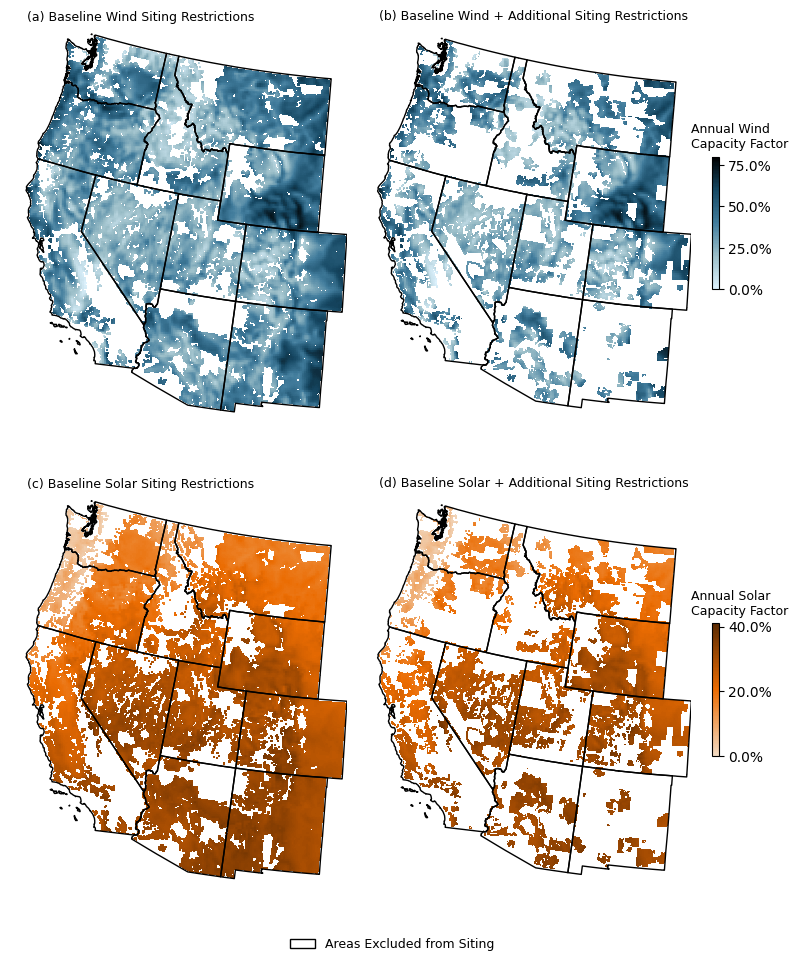

In [16]:
height = 10
width = 8

fig = plt.figure()
fig.set_figheight(height)
fig.set_figwidth(width)

spec = GridSpec(ncols=2, 
                nrows=3,
                width_ratios=[.45, .55], 
                wspace=-.5,
                hspace=0.1,
                height_ratios=[.5 ,.5, .03])


ax_1a =fig.add_subplot(spec[0,0])
ax_1b =fig.add_subplot(spec[0,1])

ax_2a =fig.add_subplot(spec[1,0])
ax_2b =fig.add_subplot(spec[1,1])

ax_leg = fig.add_subplot(spec[2,:])

raster_cmap = ListedColormap(["white", "navy"])
cmap = LinearSegmentedColormap.from_list("", [ "#DDF2FD", "#9BBEC8",'#427D9D','#164863' ,'black'], 100)
solar_cmap = LinearSegmentedColormap.from_list("", [ '#f2dac2',"#eb6c02", '#5c2b02'], 100)

wind_cmap = 'YlGn'
wind_cmap=cmap
exclusion_patch = mpatches.Patch(facecolor='white', edgecolor='black', label='Areas Excluded from Siting')

#wind_suit = os.path.join(land_area_raster_dir, 'gridcerf_wind_suitability_120m_hubheight.tif')
ax = ax_1a
with rasterio.open(base_wind_exc_path) as src2:
    data2 = src2.read(1, masked=True)

    # calculate total land
    print(f'baseline wind land (km) is {np.count_nonzero(data2)}')
    data2 = np.where(data2 == 1, 1, np.nan)

    with rasterio.open(wind_potential_path) as src1:
        data1 = src1.read(1, masked=True) 

        # calculate total generation
        suit_array = np.where(data2 == 1, 0, 1)
        gen_array = data1*suit_array*wind_unit_size_mw/1000000

        f1 = show(data1, transform=src1.transform, ax=ax, cmap=wind_cmap)
        show(data2, transform=src2.transform, ax=ax, cmap=raster_cmap)
        wecc_shp.boundary.plot(ax=ax, color = 'black', lw=1)
        ax.set_axis_off();

        print(f'baseline wind gen (TWh) is {np.sum(gen_array)}')

ax = ax_1b
exclusion_list = [base_wind_exc_path, dac_raster_path, farm_raster_path, env_1_1km_path]
with rasterio.open(wind_potential_path) as src1:
    # wind potential array
    data1 = src1.read(1, masked=True) 
    f1 = show(data1, transform=src1.transform, ax=ax, cmap=wind_cmap)
    
    for index, f in enumerate(exclusion_list):
        with rasterio.open(f) as src2:
            data2 = src2.read(1, masked=True)
            
            if index==0:
                suit_array = data2
            else:
                suit_array = data2+suit_array
                
            data2 = np.where(data2 == 1, 1, np.nan)


            
            show(data2, transform=src2.transform, ax=ax, cmap=raster_cmap)
    wecc_shp.boundary.plot(ax=ax, color = 'black', lw=1)
    ax.set_axis_off();
    norm = mpl.colors.Normalize(vmin=0, vmax=.64)
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=wind_cmap),
                ax=ax, orientation='vertical', label='', shrink=.3, pad=.05)
    cbar.ax.set_yticklabels(["{:.1%}".format(i) for i in cbar.get_ticks()]) 

    suit_array = np.where(suit_array>=1, 0, 1)
    print(f'restricted wind land (km) is {np.count_nonzero(suit_array)}')
    gen_array = data1*suit_array*wind_unit_size_mw/1000000
    print(f'restricted wind gen (TWh) is {np.sum(gen_array)}')




ax = ax_2a
with rasterio.open(base_solar_exc_path) as src2:
    data2 = src2.read(1, masked=True)
    data2 = np.where(data2 == 1, 1, np.nan)
    show(data2, transform=src2.transform, ax=ax, cmap=raster_cmap)
    with rasterio.open(solar_potential_path) as src1:
        data1 = src1.read(1, masked=True) 
        f1 = show(data1, transform=src1.transform, ax=ax, cmap=solar_cmap)
        show(data2, transform=src2.transform, ax=ax, cmap=raster_cmap)
        wecc_shp.boundary.plot(ax=ax, color = 'black', lw=1)
        ax.set_axis_off();

ax = ax_2b
exclusion_list = [base_solar_exc_path, dac_raster_path, farm_raster_path, env_1_1km_path]
with rasterio.open(solar_potential_path) as src1:
    data1 = src1.read(1, masked=True)
    f1 = show(data1, transform=src1.transform, ax=ax, cmap=solar_cmap)
    for f in exclusion_list:
        with rasterio.open(f) as src2:
            data2 = src2.read(1, masked=True)
            data2 = np.where(data2 == 1, 1, np.nan)
            show(data2, transform=src2.transform, ax=ax, cmap=raster_cmap)
    wecc_shp.boundary.plot(ax=ax, color = 'black', lw=1)
    ax.set_axis_off();
    norm = mpl.colors.Normalize(vmin=0, vmax=.41)
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=solar_cmap),
                ax=ax, orientation='vertical', label='', shrink=.3, pad=.05)
    cbar.ax.set_yticklabels(["{:.1%}".format(i) for i in cbar.get_ticks()]) # set ticks of your format


ax_leg.legend(handles=[exclusion_patch], 
           fontsize=9, 
           loc='lower center',
             frameon=False)
ax_leg.set_axis_off();
ax_1a.annotate('(a) Baseline Wind Siting Restrictions' , xy=(-2.35e6, 1.64e6), ha='left', size=9)
ax_1b.annotate('Annual Wind\nCapacity Factor' , xy=(-.505e6, .92e6), ha='left', size=9)
ax_1b.annotate('(b) Baseline Wind + Additional Siting Restrictions' , xy=(-2.35e6, 1.675e6), ha='left', size=9)
ax_2a.annotate('(c) Baseline Solar Siting Restrictions' , xy=(-2.35e6, 1.64e6), ha='left', size=9)
ax_2b.annotate('Annual Solar\nCapacity Factor' , xy=(-.505e6, .92e6), ha='left', size=9)
ax_2b.annotate('(d) Baseline Solar + Additional Siting Restrictions' , xy=(-2.35e6, 1.675e6), ha='left', size=9)
spec.tight_layout(fig)
plt.savefig(os.path.join(figure_dir, 'fig_4_generation_suitability_map.png'), dpi=300)

### Percent Differences for Case Shown in Figure 5

#### Wind (Figure 5a and 5b)

In [8]:
base = rasterio.open(base_wind_exc_path).read(1)
base_land_ex = base.sum()
wind_pot = rasterio.open(wind_potential_path).read(1)
base_rev = np.where(base ==1, 0, 1)
base_gen = base_rev * wind_pot
base_total_gen = base_gen.sum()*wind_unit_size_mw/1000000 

print(f'baseline wind excluded land (km) is {base.sum()}')
print(f'baseline wind generation potential (TWh) is {base_total_gen}')

baseline wind excluded land (km) is 1875909
baseline wind generation potential (TWh) is 42278.81990611743


In [10]:
exclusion_list = [base_wind_exc_path, dac_raster_path, farm_raster_path, env_1_1km_path]
for index, f in enumerate(exclusion_list):
    r = rasterio.open(f).read(1)
    if index == 0:
        comp_array = r
    else:
        comp_array = comp_array + r
comp_array = np.where(comp_array >=1, 1, 0)
comp_land_ex = comp_array.sum()
print(f'case #19 wind excluded land (km) is {comp_land_ex}')
comp_array_rev = np.where(comp_array ==1, 0, 1)
comp_gen = comp_array_rev * wind_pot
comp_total_gen = comp_gen.sum() * wind_unit_size_mw/1000000 
print(f'case #19 wind generation (TWh) is {comp_total_gen}')

case #19 wind excluded land (km) is 2613147
case #19 wind generation (TWh) is 16612.209933169557


In [11]:
# calculate land differences
perc = (comp_land_ex - base_land_ex) / base_land_ex
print(f'Percent increase in land excluded from baseline: {perc}')
print(f'Additional km of land excluded with case #19: {comp_land_ex - base_land_ex}')

# calculate generation differences
gen_diff = (base_total_gen - comp_total_gen) / base_total_gen
gen_diff_total = (base_total_gen - comp_total_gen) 
print(f'Percent decrease in generation from baseline: {gen_diff}')
print(f'Difference in TWh potential between baseline and case #19: {gen_diff_total}')

Percent increase in land excluded from baseline: 0.3930030721106408
Additional km of land excluded with case #19: 737238
Percent decrease in generation from baseline: 0.6070796211895713
Difference in TWh potential between baseline and case #19: 25666.609972947874


#### Solar (Figure 5c and 5d)

In [12]:
base = rasterio.open(base_solar_exc_path).read(1)
base_land_ex = base.sum()
solar_pot = rasterio.open(solar_potential_path).read(1)
base_rev = np.where(base ==1, 0, 1)
base_gen = base_rev * solar_pot
base_total_gen = base_gen.sum()*solar_unit_size_mw/1000000 

print(f'baseline solar excluded land (km) is {base.sum()}')
print(f'baseline solar generation potential (TWh) is {base_total_gen}')

baseline solar excluded land (km) is 2053230
baseline solar generation potential (TWh) is 70291.74272458375


In [13]:
exclusion_list = [base_solar_exc_path, dac_raster_path, farm_raster_path, env_1_1km_path]
for index, f in enumerate(exclusion_list):
    r = rasterio.open(f).read(1)
    if index == 0:
        comp_array = r
    else:
        comp_array = comp_array + r
comp_array = np.where(comp_array >=1, 1, 0)
comp_land_ex = comp_array.sum()
print(f'case #19 solar excluded land (km) is {comp_array.sum()}')
comp_array_rev = np.where(comp_array ==1, 0, 1)
comp_gen = comp_array_rev * solar_pot
comp_total_gen = comp_gen.sum() * solar_unit_size_mw/1000000 
print(f'case #19 solar generation (TWh) is {comp_total_gen}')

case #19 solar excluded land (km) is 2709823
case #19 solar generation (TWh) is 25419.113753763428


In [14]:
# calculate land differences
perc = (comp_land_ex - base_land_ex) / base_land_ex
print(f'Percent increase in land excluded from baseline: {perc}')
print(f'Additional km of land excluded with case #19: {comp_land_ex - base_land_ex}')

# calculate generation differences
gen_diff = (base_total_gen - comp_total_gen) / base_total_gen
gen_diff_total = (base_total_gen - comp_total_gen)
print(f'Percent decrease in generation from baseline: {gen_diff}')
print(f'Difference in TWh potential between baseline and case #19: {gen_diff_total}')

Percent increase in land excluded from baseline: 0.3197854112788144
Additional km of land excluded with case #19: 656593
Percent decrease in generation from baseline: 0.6383769591065583
Difference in TWh potential between baseline and case #19: 44872.62897082032
